In [2]:
from pyspark import SparkContext
from pyspark.sql.functions import concat_ws, to_timestamp, col
from pyspark.sql.functions import hour, dayofmonth, month, year, avg, when
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from scipy.stats import zscore
import pandas as pd
import datetime
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam, SGD, RMSprop, Adagrad
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, ParameterGrid
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from dateutil.parser import parse
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
import warnings 
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
#Create a Spark session
spark = SparkSession.builder.appName("PowerConsump").getOrCreate()

24/09/28 01:09:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
#Load the file
df = spark.read.option("header", "true").option("delimiter", ";").csv("hdfs://localhost:9000/user1/household_power_consumption.txt")
    
#Show
df.show(5)


+----------+--------+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|      Date|    Time|Global_active_power|Global_reactive_power|Voltage|Global_intensity|Sub_metering_1|Sub_metering_2|Sub_metering_3|
+----------+--------+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|16/12/2006|17:24:00|              4.216|                0.418|234.840|          18.400|         0.000|         1.000|        17.000|
|16/12/2006|17:25:00|              5.360|                0.436|233.630|          23.000|         0.000|         1.000|        16.000|
|16/12/2006|17:26:00|              5.374|                0.498|233.290|          23.000|         0.000|         2.000|        17.000|
|16/12/2006|17:27:00|              5.388|                0.502|233.740|          23.000|         0.000|         1.000|        17.000|
|16/12/2006|17:28:00|              3.666|                0.528

In [4]:
#check the columns
df.columns

['Date',
 'Time',
 'Global_active_power',
 'Global_reactive_power',
 'Voltage',
 'Global_intensity',
 'Sub_metering_1',
 'Sub_metering_2',
 'Sub_metering_3']

In [5]:
#Register as temporary SQL table
df.createOrReplaceTempView("power_data")

#Query the data by selecting Global Active Power
query = """
    SELECT 
        CONCAT(Date, ' ', Time) as datetime, 
        Sub_metering_3
    FROM power_data
"""

#Execute the query
gap_df = spark.sql(query)

#Show the first few rows
gap_df.show()

+-------------------+--------------+
|           datetime|Sub_metering_3|
+-------------------+--------------+
|16/12/2006 17:24:00|        17.000|
|16/12/2006 17:25:00|        16.000|
|16/12/2006 17:26:00|        17.000|
|16/12/2006 17:27:00|        17.000|
|16/12/2006 17:28:00|        17.000|
|16/12/2006 17:29:00|        17.000|
|16/12/2006 17:30:00|        17.000|
|16/12/2006 17:31:00|        17.000|
|16/12/2006 17:32:00|        17.000|
|16/12/2006 17:33:00|        16.000|
|16/12/2006 17:34:00|        17.000|
|16/12/2006 17:35:00|        17.000|
|16/12/2006 17:36:00|        16.000|
|16/12/2006 17:37:00|        17.000|
|16/12/2006 17:38:00|        17.000|
|16/12/2006 17:39:00|        17.000|
|16/12/2006 17:40:00|        17.000|
|16/12/2006 17:41:00|        17.000|
|16/12/2006 17:42:00|        18.000|
|16/12/2006 17:43:00|        17.000|
+-------------------+--------------+
only showing top 20 rows



In [6]:
#delete the whole data 
#del df 

In [7]:
#showing the new dataset
gap_df.describe().show()

+-------+-----------------+-----------------+
|summary|         datetime|   Sub_metering_3|
+-------+-----------------+-----------------+
|  count|          2075259|          2049280|
|   mean|             null| 6.45844735712055|
| stddev|             null|8.437153908665449|
|    min|1/1/2007 00:00:00|            0.000|
|    max|9/9/2010 23:59:00|            9.000|
+-------+-----------------+-----------------+



In [8]:
#Filter for ? values 
gap_df.filter(gap_df["Sub_metering_3"] == "?").show()

+--------+--------------+
|datetime|Sub_metering_3|
+--------+--------------+
+--------+--------------+



In [9]:
#Finding the missing values
total_rows = gap_df.count()
for i in gap_df.columns:
    null_count = gap_df.filter(col(i).isNull()).count()
    null_percentage = (null_count / total_rows) * 100
    print(f"Column {i} has {null_percentage:.2f}% null values")


Column datetime has 0.00% null values
Column Sub_metering_3 has 1.25% null values


In [10]:
#Transforming the dataset into pandas dataset
df_pandas = gap_df.toPandas()

In [11]:
#checking the new pandas df
df_pandas.head()

,datetime,Sub_metering_3
0,16/12/2006 17:24:00,17.000
1,16/12/2006 17:25:00,16.000
2,16/12/2006 17:26:00,17.000
3,16/12/2006 17:27:00,17.000
4,16/12/2006 17:28:00,17.000


In [12]:
#Convert 'datetime' column to actual datetime type
df_pandas['datetime'] = pd.to_datetime(df_pandas['datetime'], format='%d/%m/%Y %H:%M:%S')
df_pandas['Sub_metering_3'] = pd.to_numeric(df_pandas['Sub_metering_3'], errors='coerce')

In [13]:
#set datetime as index column
df_pandas.set_index('datetime', inplace=True)

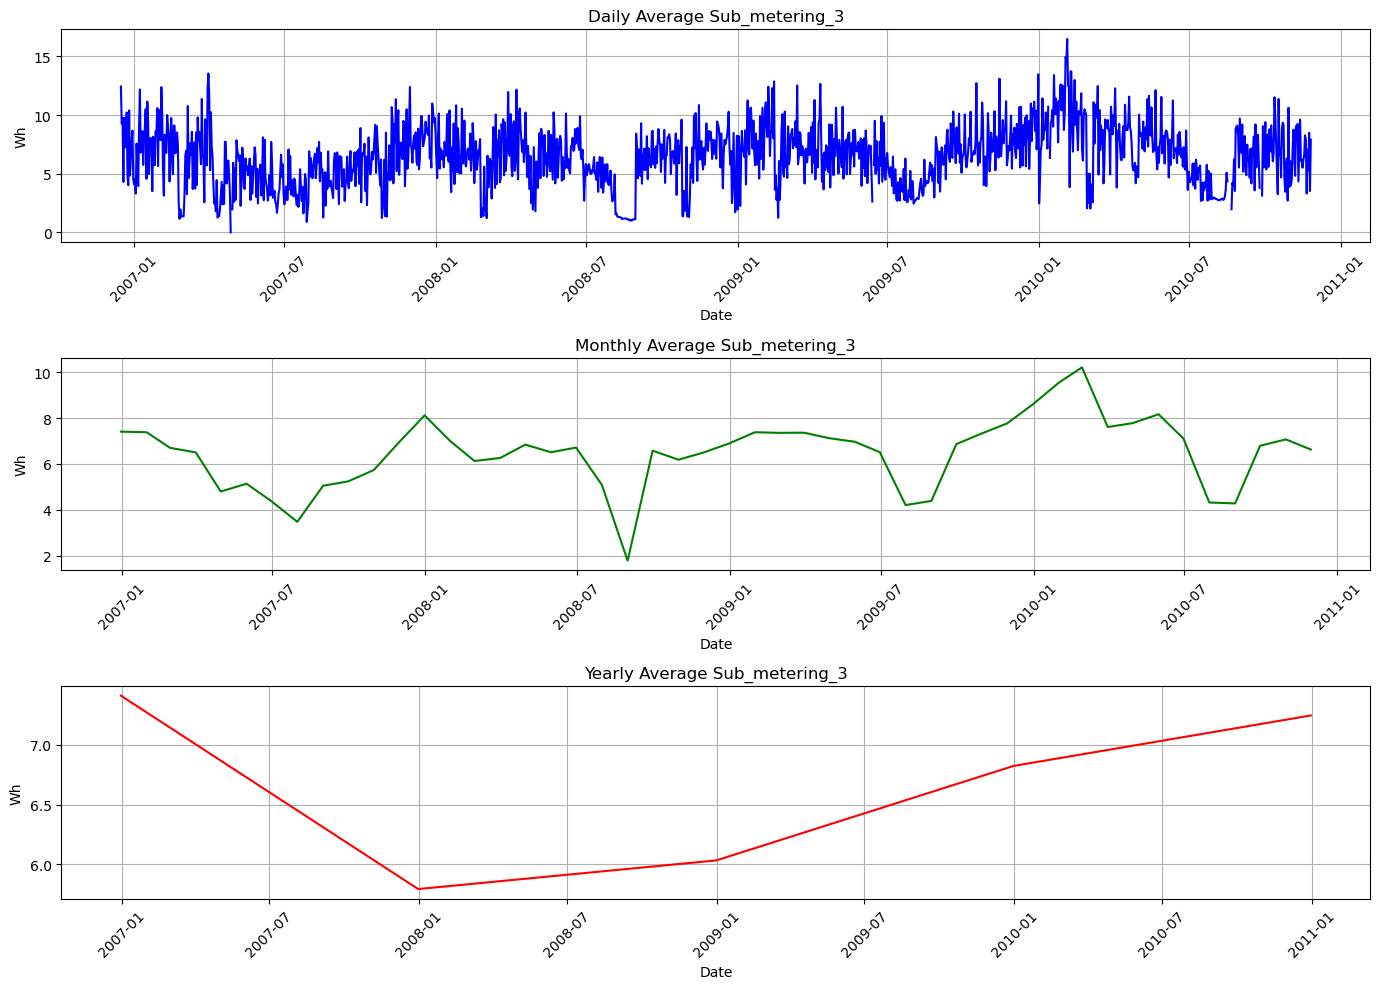

In [14]:
#Resample the data to daily, monthly, and yearly averages
daily_avg_power = df_pandas['Sub_metering_3'].resample('D').mean()
monthly_avg_power = df_pandas['Sub_metering_3'].resample('ME').mean()
yearly_avg_power = df_pandas['Sub_metering_3'].resample('YE').mean()

#Create subplots
plt.figure(figsize=(14, 10))

#Daily average
plt.subplot(3, 1, 1)
plt.plot(daily_avg_power.index, daily_avg_power, label='Daily Avg', color='blue')
plt.title('Daily Average Sub_metering_3')
plt.xlabel('Date')
plt.ylabel('Wh')
plt.xticks(rotation=45)
plt.grid(True)

#Monthly average
plt.subplot(3, 1, 2)  
plt.plot(monthly_avg_power.index, monthly_avg_power, label='Monthly Avg', color='green')
plt.title('Monthly Average Sub_metering_3')
plt.xlabel('Date')
plt.ylabel('Wh')
plt.xticks(rotation=45)
plt.grid(True)

#Yearly average
plt.subplot(3, 1, 3)  
plt.plot(yearly_avg_power.index, yearly_avg_power, label='Yearly Avg', color='red')
plt.title('Yearly Average Sub_metering_3')
plt.xlabel('Date')
plt.ylabel('Wh')
plt.xticks(rotation=45)
plt.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

In [15]:
#Creating a dataset without Nan values
df_clean = df_pandas.dropna(subset=['Sub_metering_3'])
#Daily average 
df_daily_avg = df_pandas['Sub_metering_3'].resample('D').mean().dropna()


In [16]:
#creating a new dataset identical to df_clean but now adding random nan values in order to compare them
np.random.seed(33)  # Set seed for reproducibility
n_nan = int(len(df_daily_avg) * 0.1)  # Introduce NaN in 10% of the data
nan_indices = np.random.choice(df_daily_avg.index, n_nan, replace=False)
df_with_missing = df_daily_avg.copy()
df_with_missing.loc[nan_indices] = np.nan

In [17]:
#Applying different techniques and comparing
##Forward Fill
df_ffill = df_with_missing.ffill()

##Backward Fill
df_bfill = df_with_missing.bfill()

##Linear Interpolation
df_linear = df_with_missing.interpolate(method='linear')

##Cubic Interpolation
df_cubic = df_with_missing.interpolate(method='cubic')

##Seasonal Mean
def seasonal_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas)
    return out

df_with_missing_seasonal = pd.Series(seasonal_mean(df_with_missing.values, n=7), index=df_with_missing.index)


In [18]:
#Calculate MSE for each method
def calculate_mse(original, filled):
#Filter out NaN values
    non_nan_indices = original.notna() & filled.notna()
    return np.round(mean_squared_error(original[non_nan_indices], filled[non_nan_indices]), 4)

mse_ffill = calculate_mse(df_daily_avg, df_ffill)
mse_bfill = calculate_mse(df_daily_avg, df_bfill)
mse_linear = calculate_mse(df_daily_avg, df_linear)
mse_cubic = calculate_mse(df_daily_avg, df_cubic)
mse_seasonal = calculate_mse(df_daily_avg, df_with_missing_seasonal)

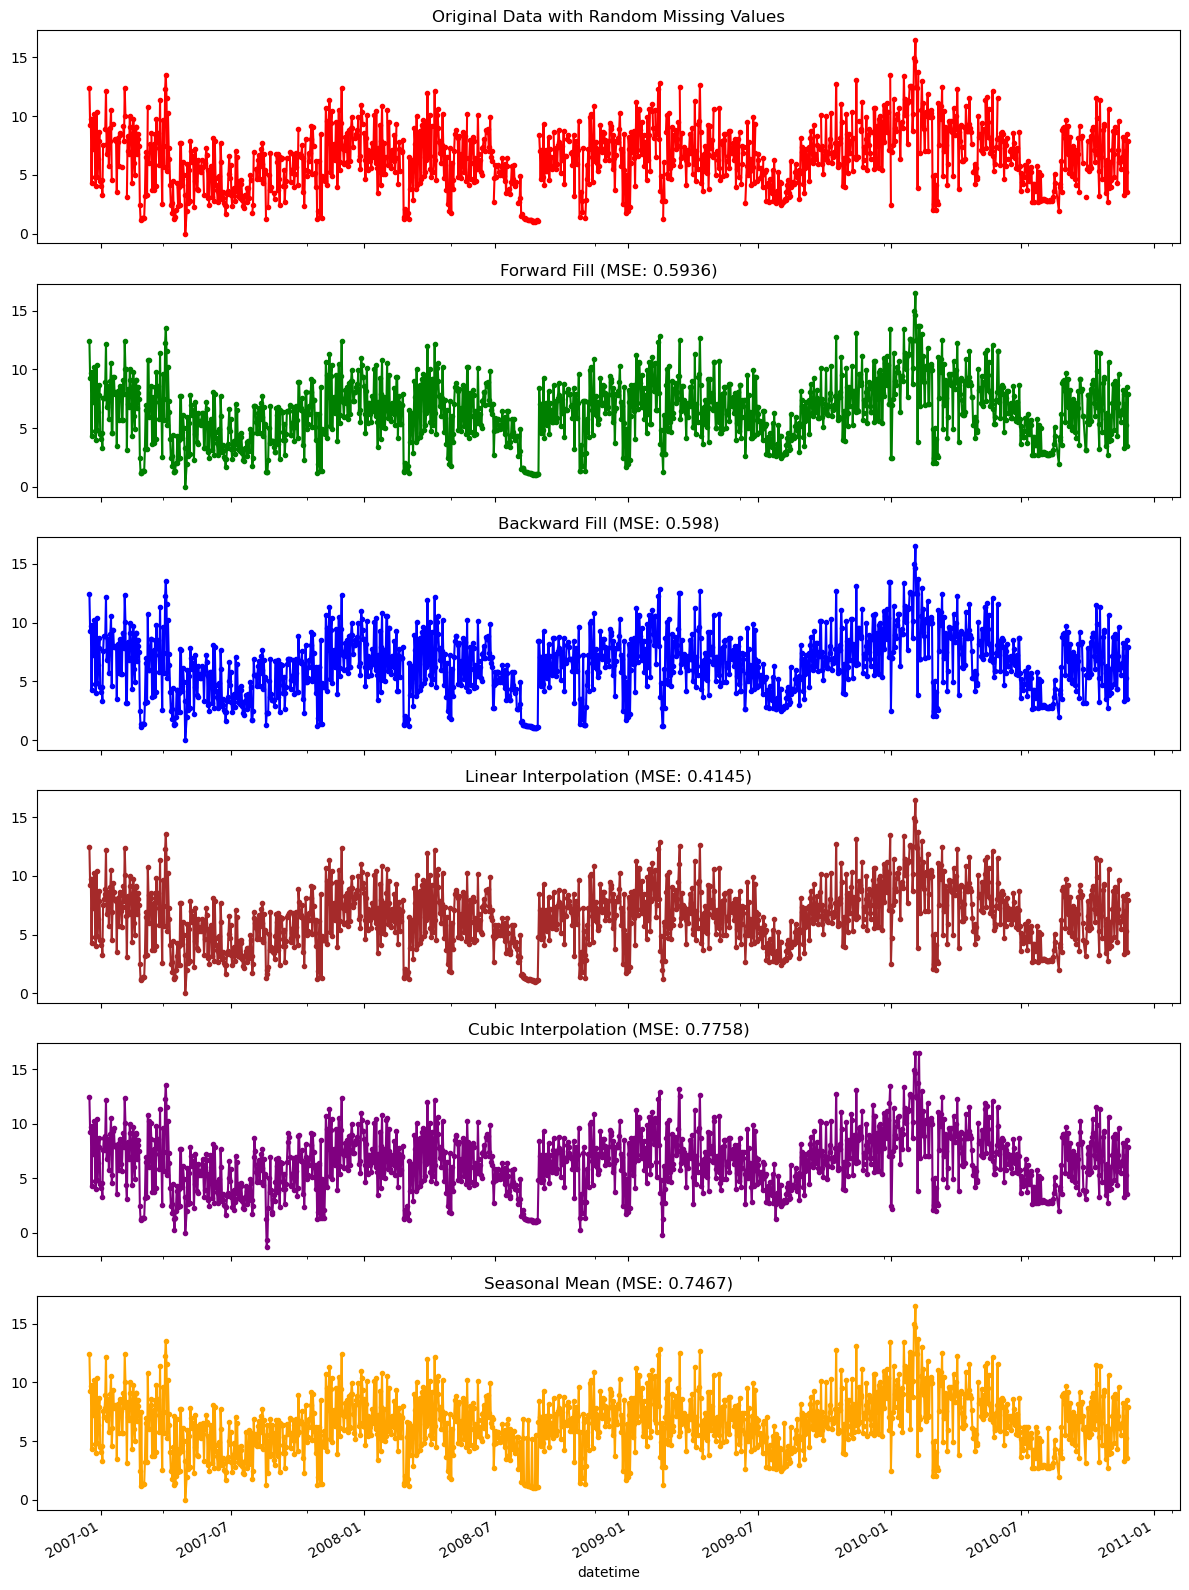

In [19]:
#Plot the results
fig, axes = plt.subplots(6, 1, sharex=True, figsize=(12, 16))

##Plot the original data with missing values
df_with_missing.plot(ax=axes[0], color='red', style=".-", title='Original Data with Random Missing Values')

##Forward Fill
df_ffill.plot(ax=axes[1], color='green', style=".-", title=f'Forward Fill (MSE: {mse_ffill})')

##Backward Fill
df_bfill.plot(ax=axes[2], color='blue', style=".-", title=f'Backward Fill (MSE: {mse_bfill})')

##Linear Interpolation
df_linear.plot(ax=axes[3], color='brown', style=".-", title=f'Linear Interpolation (MSE: {mse_linear})')

##Cubic Interpolation
df_cubic.plot(ax=axes[4], color='purple', style=".-", title=f'Cubic Interpolation (MSE: {mse_cubic})')

##Seasonal Mean
df_with_missing_seasonal.plot(ax=axes[5], color='orange', style=".-", title=f'Seasonal Mean (MSE: {mse_seasonal})')

#Adjust layout and show the plot
plt.tight_layout()
plt.show()

***Linear Interpolation outperformed the other techniques***

In [20]:
#creating a copy of 
df_pandas_avg = df_daily_avg.copy()
df_pandas_avg = df_with_missing.interpolate(method='linear')


In [21]:
#checking for missing values
null_count = df_pandas_avg.isnull().sum()
total_rows = len(df_pandas_avg)
null_percentage = (null_count / total_rows) * 100
print(f" Daily average dataset has {null_percentage:.2f}% null values")

 Daily average dataset has 0.00% null values


*****Anomaly detection***** 

***Z-score***

In [22]:
#creating a copy of the daily average data
df_daily_avg_zscore = df_daily_avg.copy()
#convert series into a dataframe
df_daily_avg_zscore = df_daily_avg_zscore.to_frame()
#Calculate Z-scores and store it in a new column
df_daily_avg_zscore['zscore'] = zscore(df_daily_avg_zscore)

In [23]:
#checking
df_daily_avg_zscore.head()

,Sub_metering_3,zscore
datetime,,
2006-12-16,12.439394,2.334542
2006-12-17,9.264583,1.098284
2006-12-18,9.734722,1.281354
2006-12-19,4.303472,-0.833551
2006-12-20,9.765972,1.293523


In [24]:
#Find anomalies where Z-score is > threshold
threshold = 3
#separating the anomalies according to predefined threshold
df_daily_avg_zscore['anomaly'] = (df_daily_avg_zscore['zscore'].abs() > threshold)

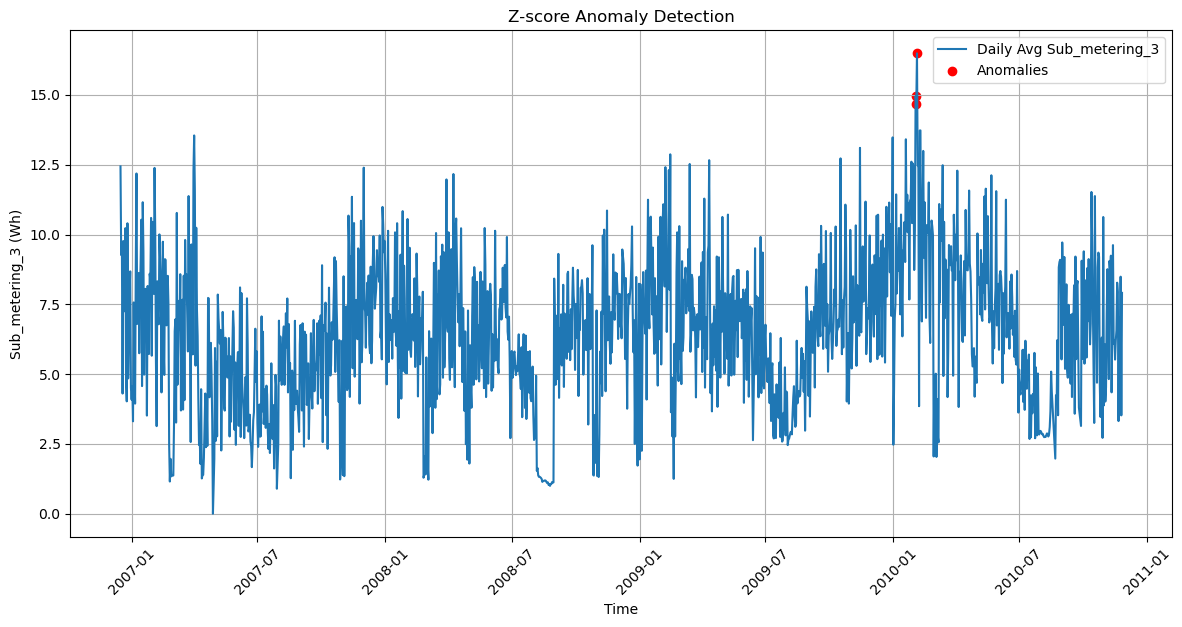

In [149]:
#Plot results
plt.figure(figsize=(12,6))
plt.plot(df_daily_avg_zscore.index, df_daily_avg_zscore['Sub_metering_3'], label='Daily Avg Sub_metering_3')
plt.scatter(df_daily_avg_zscore.index[df_daily_avg_zscore['anomaly']], 
            df_daily_avg_zscore['Sub_metering_3'][df_daily_avg_zscore['anomaly']], 
            color='red', label='Anomalies')
plt.xlabel('Time')
plt.ylabel('Sub_metering_3 (Wh)')
plt.title('Z-score Anomaly Detection')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig('zscore_anomaly_detection.png', format='png', dpi=300)
plt.show()

In [26]:
#Print the anomalies
print("Anomalies detected (dates and corresponding Sub_metering_3):")
anomalies_data = df_daily_avg_zscore[df_daily_avg_zscore['anomaly']]
print(anomalies_data[['Sub_metering_3']])

Anomalies detected (dates and corresponding Sub_metering_3):
            Sub_metering_3
datetime                  
2010-02-02       14.955556
2010-02-03       14.673611
2010-02-04       16.488194


***Isolation Forest*** 

In [27]:
#Scale the data 
scaler = StandardScaler()

#Converting 1D array into a 2D array and applying scaler 
daily_avg_scaled = scaler.fit_transform(df_pandas_avg.values.reshape(-1, 1))

#Apply Isolation Forest and its parameters
iso_forest = IsolationForest(contamination=0.01, max_samples = 0.8, n_estimators = 100,random_state=11)
anomalies_iso_forest = iso_forest.fit_predict(daily_avg_scaled)

#Mark anomalies where the prediction is -1
anomalies_iso_forest = anomalies_iso_forest == -1

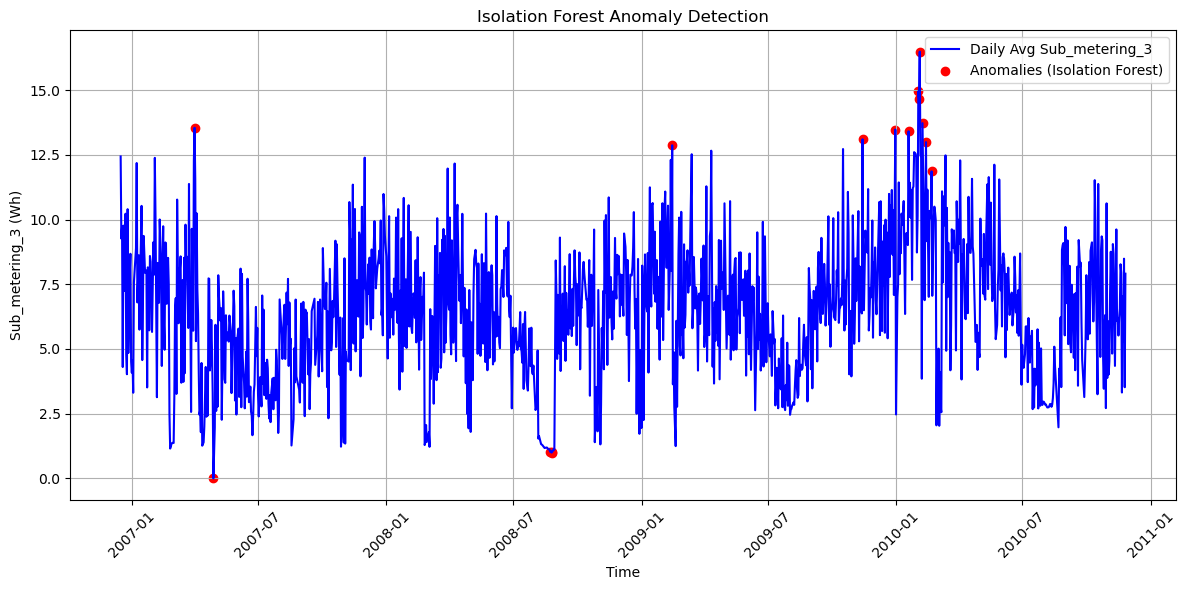

In [28]:
#Plotting the first IF 
plt.figure(figsize=(12,6))
plt.plot(df_pandas_avg.index, df_pandas_avg, label='Daily Avg Sub_metering_3', color='blue')
plt.scatter(df_pandas_avg.index[anomalies_iso_forest], df_pandas_avg[anomalies_iso_forest], color='red', label='Anomalies (Isolation Forest)')
plt.xlabel('Time')
plt.ylabel('Sub_metering_3 (Wh)')
plt.title('Isolation Forest Anomaly Detection')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
#printing the anomalies detected
print("Anomalies detected by Isolation Forest:")
print(df_pandas_avg[anomalies_iso_forest])

Anomalies detected by Isolation Forest:
datetime
2007-04-01    13.547917
2007-04-28     0.000000
2008-08-23     1.031250
2008-08-25     0.997222
2008-08-26     1.032986
2009-02-14    12.871349
2009-11-14    13.102778
2009-12-31    13.478472
2010-01-19    13.410417
2010-02-02    14.955556
2010-02-03    14.673611
2010-02-04    16.488194
2010-02-08    13.725000
2010-02-13    12.993056
2010-02-21    11.863194
Name: Sub_metering_3, dtype: float64


In [30]:
#Applying IF under different parameters
iso_forest_1 = IsolationForest(contamination=0.05, max_samples=0.7, n_estimators=150, random_state=11)
anomalies_iso_forest_1 = iso_forest_1.fit_predict(daily_avg_scaled)
anomalies_iso_forest_1 = anomalies_iso_forest_1 == -1

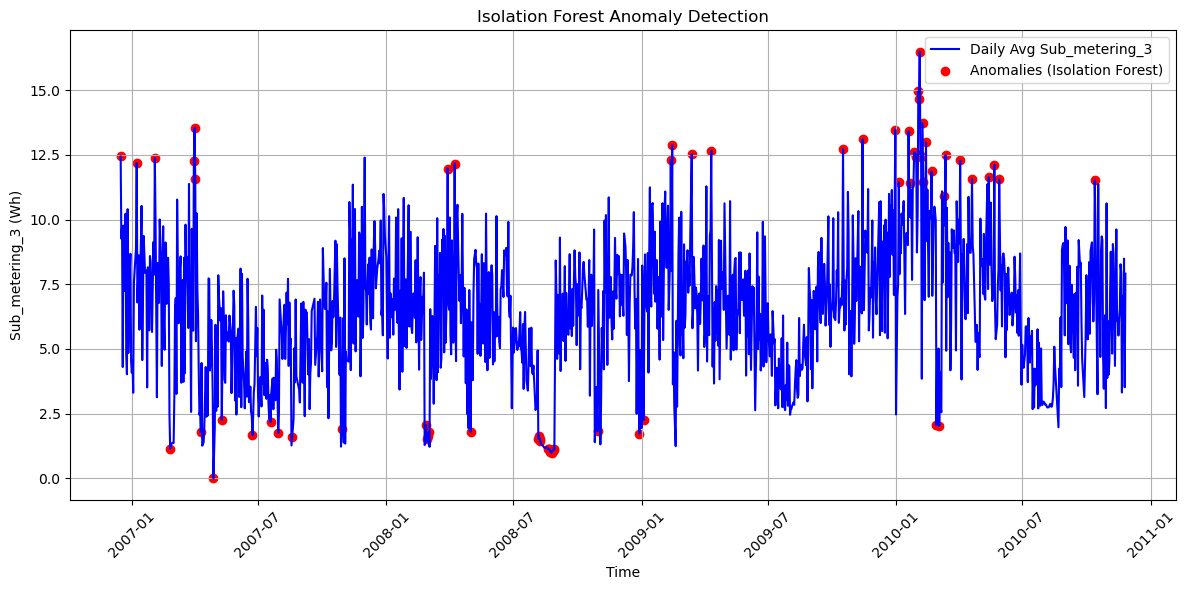

In [31]:
#plotting
plt.figure(figsize=(12,6))
plt.plot(df_pandas_avg.index, df_pandas_avg, label='Daily Avg Sub_metering_3', color='blue')
plt.scatter(df_pandas_avg.index[anomalies_iso_forest_1], df_pandas_avg[anomalies_iso_forest_1 ], color='red', label='Anomalies (Isolation Forest)')
plt.xlabel('Time')
plt.ylabel('Sub_metering_3 (Wh)')
plt.title('Isolation Forest Anomaly Detection')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
#checking the anomalies idenfied
print("Anomalies detected by Isolation Forest:")
print(df_pandas_avg[anomalies_iso_forest_1])

Anomalies detected by Isolation Forest:
datetime
2006-12-16    12.439394
2007-01-08    12.185417
2007-02-03    12.384722
2007-02-25     1.152778
2007-03-31    12.279167
                ...    
2010-04-20    11.575000
2010-05-14    11.641667
2010-05-22    12.120833
2010-05-29    11.552083
2010-10-13    11.522917
Name: Sub_metering_3, Length: 72, dtype: float64


In [33]:
#Third Isolation Forest, with different parameters
iso_forest_2 = IsolationForest(contamination=0.02, n_estimators=200, max_samples=0.9, random_state=11)
anomalies_iso_forest_2 = iso_forest_2.fit_predict(daily_avg_scaled)
anomalies_iso_forest_2 = anomalies_iso_forest_2 == -1

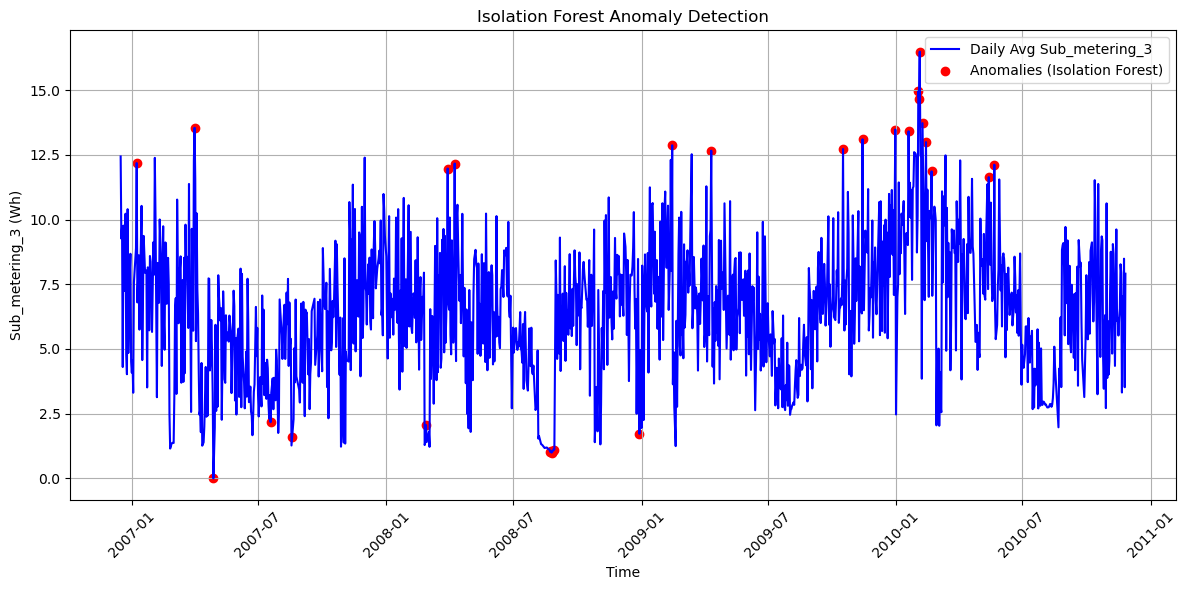

In [34]:
#plotting
plt.figure(figsize=(12,6))
plt.plot(df_pandas_avg.index, df_pandas_avg, label='Daily Avg Sub_metering_3', color='blue')
plt.scatter(df_pandas_avg.index[anomalies_iso_forest_2], df_pandas_avg[anomalies_iso_forest_2], color='red', label='Anomalies (Isolation Forest)')
plt.xlabel('Time')
plt.ylabel('Sub_metering_3 (Wh)')
plt.title('Isolation Forest Anomaly Detection')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [150]:
#checking the anomalis identified
print("Anomalies detected by Isolation Forest:")
print(df_pandas_avg[anomalies_iso_forest_2])
len(df_pandas_avg[anomalies_iso_forest_2])

Anomalies detected by Isolation Forest:
datetime
2007-01-08    12.185417
2007-04-01    13.547917
2007-04-28     0.000000
2007-07-19     2.173611
2007-08-19     1.610185
2008-02-27     2.061806
2008-03-29    11.972222
2008-04-08    12.165972
2008-08-23     1.031250
2008-08-24     1.057639
2008-08-25     0.997222
2008-08-26     1.032986
2008-08-27     1.068750
2008-08-29     1.110417
2008-12-29     1.722222
2009-02-14    12.871349
2009-04-11    12.661806
2009-10-17    12.726389
2009-11-14    13.102778
2009-12-31    13.478472
2010-01-19    13.410417
2010-02-02    14.955556
2010-02-03    14.673611
2010-02-04    16.488194
2010-02-08    13.725000
2010-02-13    12.993056
2010-02-21    11.863194
2010-05-14    11.641667
2010-05-22    12.120833
Name: Sub_metering_3, dtype: float64


29

***LSTM***

In [62]:
#Scale the data 
scaler = StandardScaler()

#Transforming a 1d array into a 2d
daily_avg_scaled = scaler.fit_transform(df_pandas_avg.values.reshape(-1, 1))

In [67]:
#Creating a time-step for LSTM TS prediction
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

Time Steps:
The number of past observations used to predict future values, allowing the model to learn from historical data.

In [68]:
#Trying different time steps
time_steps_list = [10, 20, 30, 50]
#storing the results
results = []

Training with time_steps = 10
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9684 - val_loss: 0.5397
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6621 - val_loss: 0.5203
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6258 - val_loss: 0.5135
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6749 - val_loss: 0.5135
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6190 - val_loss: 0.5154
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6140 - val_loss: 0.5111
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6291 - val_loss: 0.5156
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6345 - val_loss: 0.5211
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6360 - val_loss: 0.5226
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6131 - val_loss: 0.5178
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train MSE with time_steps = 10: 0.6104617797924623


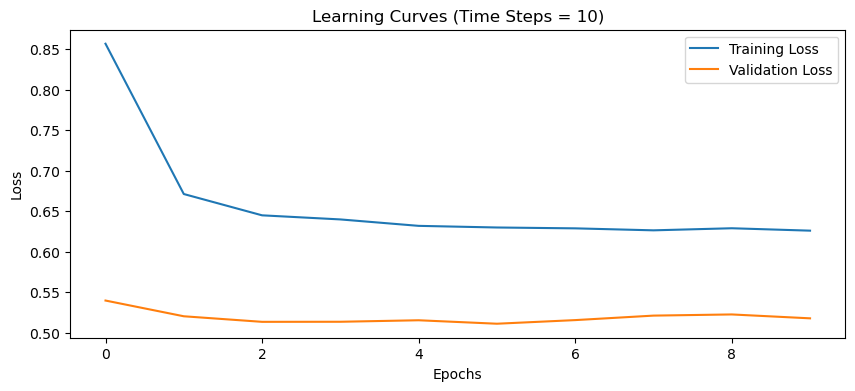

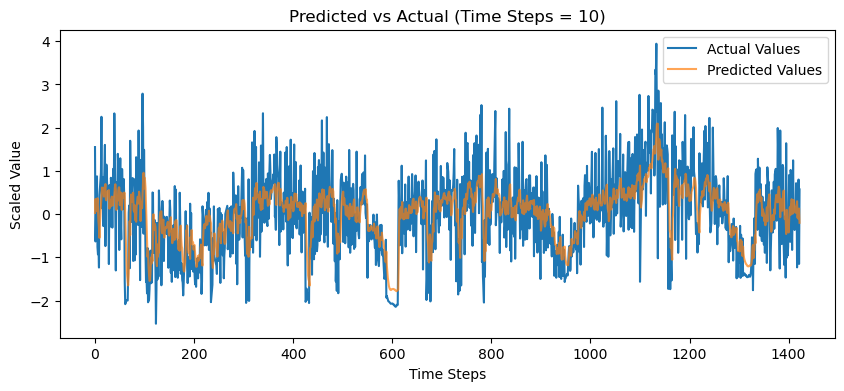

Training with time_steps = 20
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9580 - val_loss: 0.5752
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6453 - val_loss: 0.5415
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6427 - val_loss: 0.5250
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6213 - val_loss: 0.5224
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6312 - val_loss: 0.5237
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6210 - val_loss: 0.5216
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6581 - val_loss: 0.5234
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6053 - val_loss: 0.5211
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6025 - val_loss: 0.5273
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5738 - val_loss: 0.5174
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train MSE with time_steps = 20: 0.6073042252598589


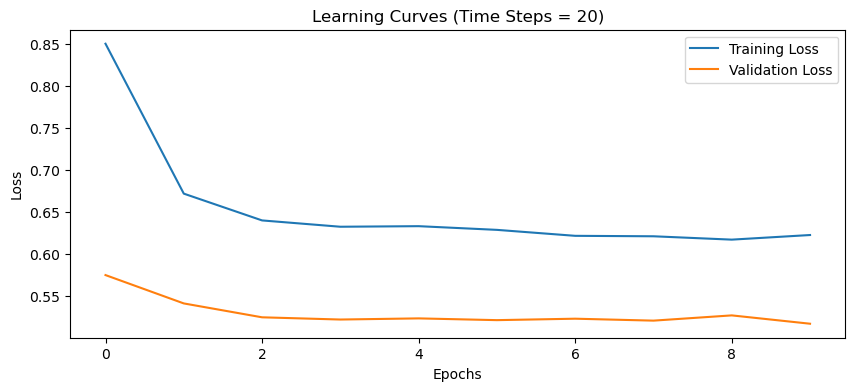

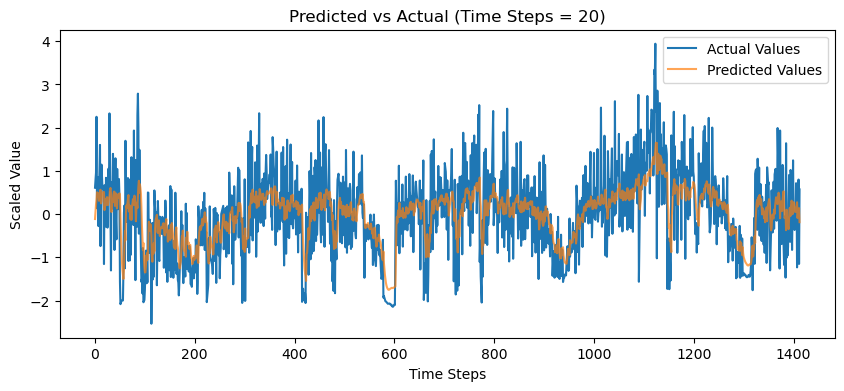

Training with time_steps = 30
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8290 - val_loss: 0.5426
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6473 - val_loss: 0.5182
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6508 - val_loss: 0.5166
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6377 - val_loss: 0.5205
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ -2s -64216us/step - loss: 0.6441 - val_loss: 0.5246
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6305 - val_loss: 0.5158
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6464 - val_loss: 0.5368
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6514 - val_loss: 0.5184
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6087 - val_loss: 0.5242
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6279 - val_loss: 0.5190
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train MSE with time_steps = 30: 0.5961661279555688


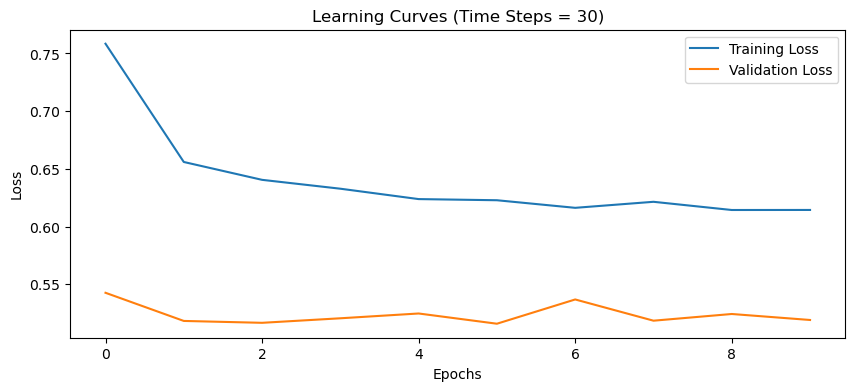

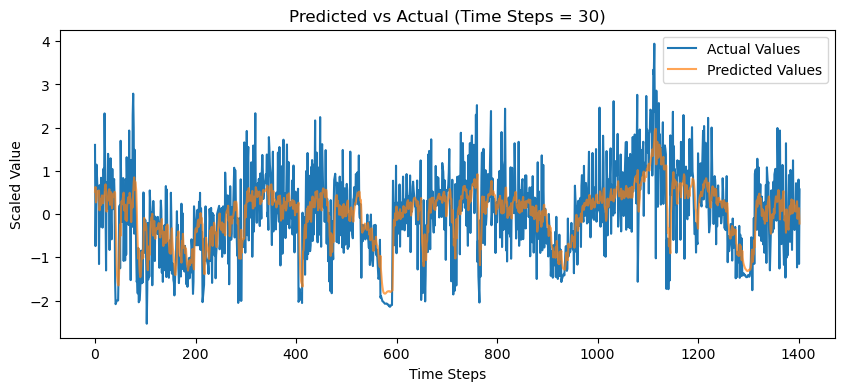

Training with time_steps = 50
Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9089 - val_loss: 0.5877
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6922 - val_loss: 0.5810
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7052 - val_loss: 0.5730
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6835 - val_loss: 0.5599
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6216 - val_loss: 0.5534
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6810 - val_loss: 0.5437
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6767 - val_loss: 0.5395
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6716 - val_loss: 0.5410
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6444 - val_loss: 0.5340
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6191 - val_loss: 0.5360
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Train MSE with time_steps = 50: 0.6206925015434389


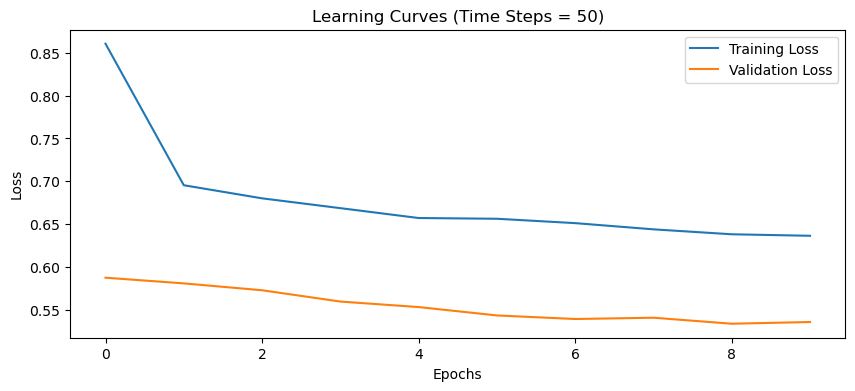

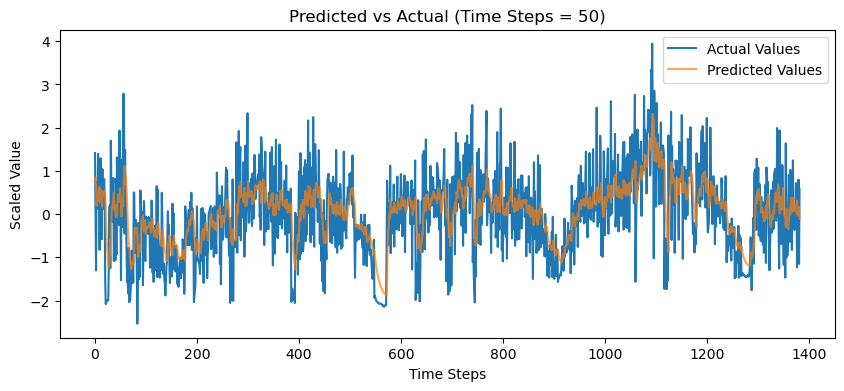

In [69]:
#iterating through the time steps 
for time_steps in time_steps_list:
    #Preparing the data for the time stamps 
    X, y = create_sequences(daily_avg_scaled, time_steps)

    #Reshaping X to be samples, time steps, features
    X = X.reshape((X.shape[0], X.shape[1], 1))

    #LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
    model.add(Dense(1))
    
    #Compile
    model.compile(optimizer=Adam(), loss='mse')
    
    #Train the model and store it
    print(f"Training with time_steps = {time_steps}")
    #fit the model
    history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.1, verbose=1)
    
    #Evaluate using mean squared error
    y_pred = model.predict(X)
    train_mse = mean_squared_error(y, y_pred)
    print(f"Train MSE with time_steps = {time_steps}: {train_mse}")

    #Append the results
    results.append({
        'time_steps': time_steps,
        'train_loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'train_mse': train_mse
    })

    #Plotting learning curves
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Learning Curves (Time Steps = {time_steps})")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    #Plotting predict x actual values
    plt.figure(figsize=(10, 4))
    plt.plot(y, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values', alpha=0.7)
    plt.title(f"Predicted vs Actual (Time Steps = {time_steps})")
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.show()

In [70]:
#transforming the results into a dataframe
results_df = pd.DataFrame(results)

#showing the results
print(results_df[['time_steps', 'train_mse']])

   time_steps  train_mse
0          10   0.610462
1          20   0.607304
2          30   0.596166
3          50   0.620693


Dropout:
A technique used to prevent overfitting by randomly disabling neurons during training, encouraging the model to generalize better.

In [71]:
#choosing the best time step
time_steps = 30
#creating the sequences
X, y = create_sequences(daily_avg_scaled, time_steps)
#Reshaping X to be samples, time steps, features
X = X.reshape((X.shape[0], X.shape[1], 1))

In [72]:
#dropouts 
dropout_rates = [0.0, 0.2, 0.4, 0.6]
#empty results to store it
results = []

Training with dropout_rate = 0.0
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8806 - val_loss: 0.5477
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6741 - val_loss: 0.5291
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6201 - val_loss: 0.5145
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6466 - val_loss: 0.5250
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6555 - val_loss: 0.5194
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6214 - val_loss: 0.5198
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6563 - val_loss: 0.5170
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6506 - val_loss: 0.5202
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6505 - val_loss: 0.5203
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6378 - val_loss: 0.5194
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train MSE with dropout_rate = 0.0: 0.609112601397147


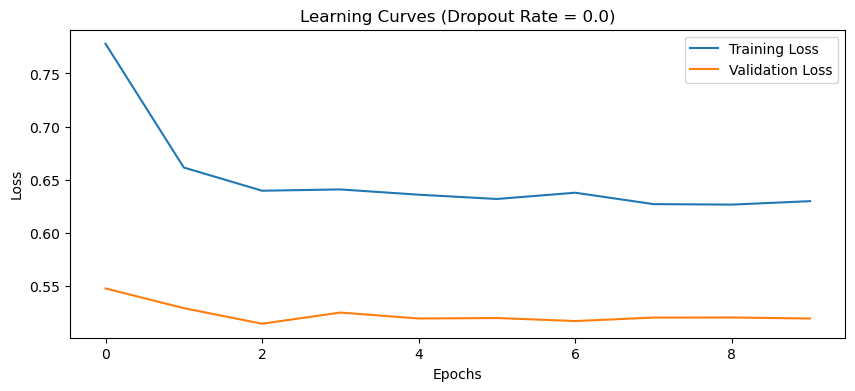

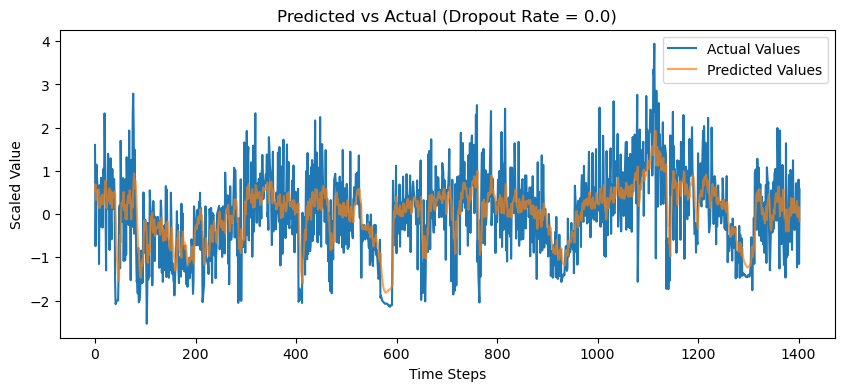

Training with dropout_rate = 0.2
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8932 - val_loss: 0.5862
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7499 - val_loss: 0.5460
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6754 - val_loss: 0.5346
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7072 - val_loss: 0.5288
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6295 - val_loss: 0.5293
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6687 - val_loss: 0.5211
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6774 - val_loss: 0.5276
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6170 - val_loss: 0.5187
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6364 - val_loss: 0.5136
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6620 - val_loss: 0.5145
44/44 ━━━━━━━━━━━━━━━━━━━━ -2s 4ms/step     
Train MSE with dropout_rate = 0.2: 0.6093449746125382


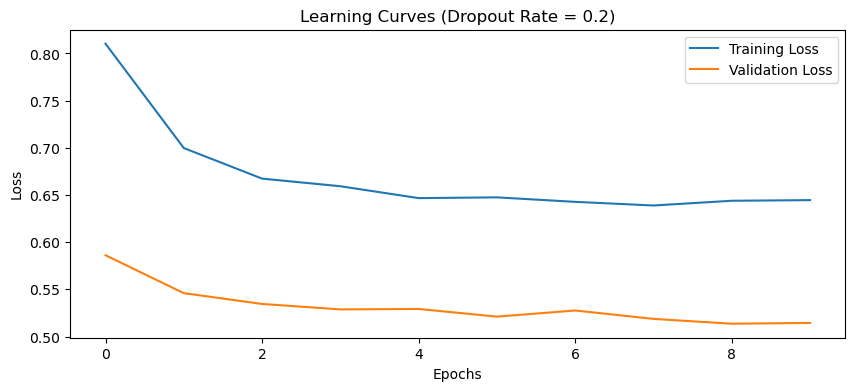

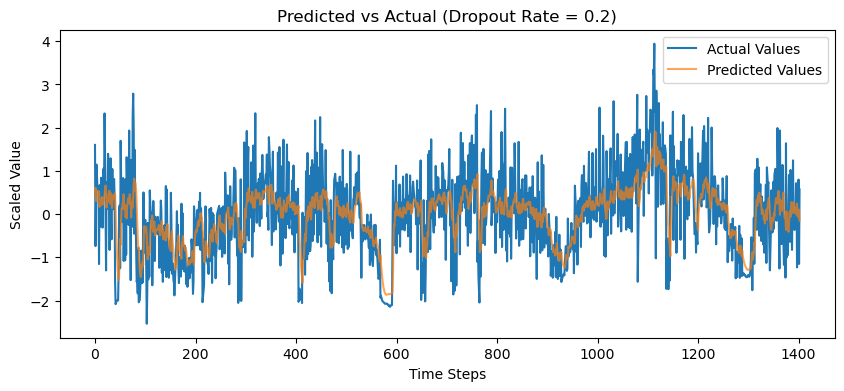

Training with dropout_rate = 0.4
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7902 - val_loss: 0.5377
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6654 - val_loss: 0.5235
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6566 - val_loss: 0.5173
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6312 - val_loss: 0.5332
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6460 - val_loss: 0.5212
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6848 - val_loss: 0.5137
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6544 - val_loss: 0.5127
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6302 - val_loss: 0.5142
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6591 - val_loss: 0.5158
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6252 - val_loss: 0.5152
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Train MSE with dropout_rate = 0.4: 0.6050067026424537


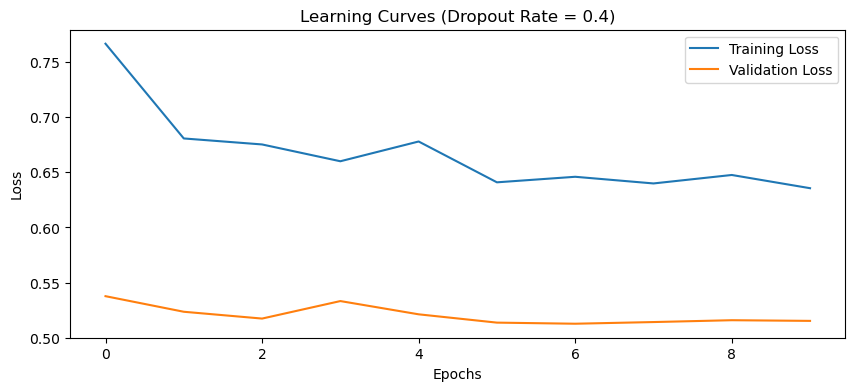

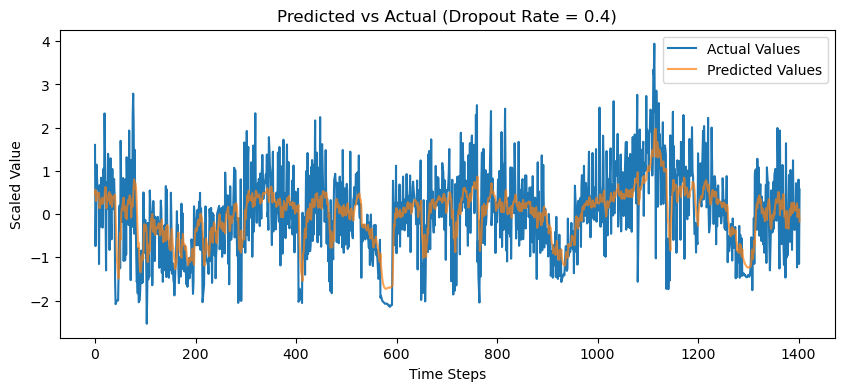

Training with dropout_rate = 0.6
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8806 - val_loss: 0.5687
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7168 - val_loss: 0.5307
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6733 - val_loss: 0.5258
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6978 - val_loss: 0.5288
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6715 - val_loss: 0.5240
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6630 - val_loss: 0.5267
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6465 - val_loss: 0.5212
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6828 - val_loss: 0.5201
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6429 - val_loss: 0.5163
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6604 - val_loss: 0.5232
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train MSE with dropout_rate = 0.6: 0.6156543317784688


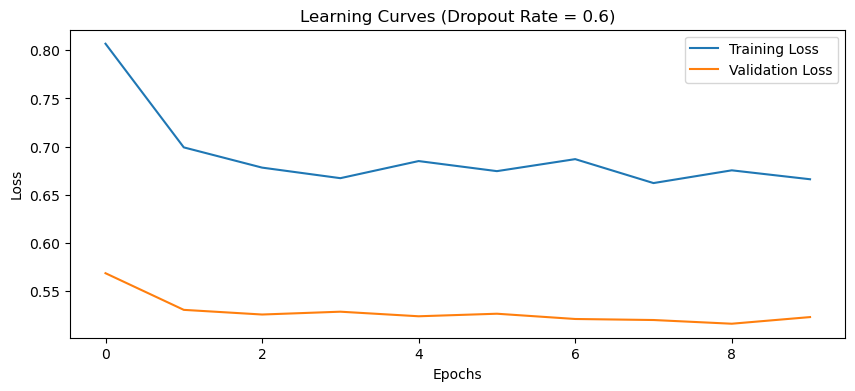

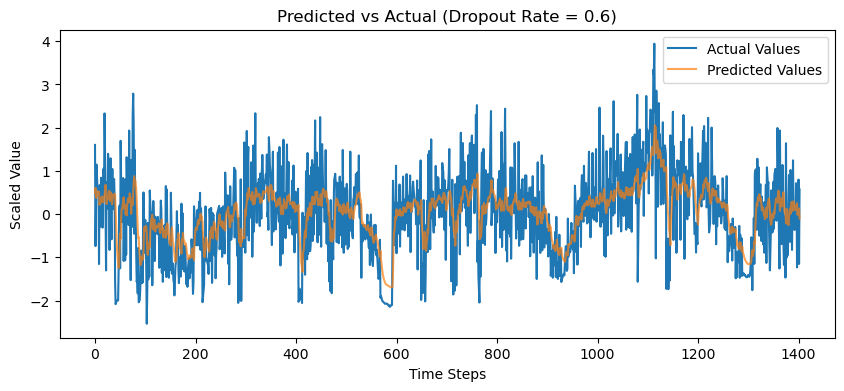

In [73]:
#iterating through the dropouts
for dropout_rate in dropout_rates:
    #Building the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
    
    # checks if greater than 0. If it is, then adds a dropout.
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))
    
    #Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    #Train the model and store it
    print(f"Training with dropout_rate = {dropout_rate}")
    history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.1, verbose=1)
    
    #Evaluate using MSE
    y_pred = model.predict(X)
    train_mse = mean_squared_error(y, y_pred)
    print(f"Train MSE with dropout_rate = {dropout_rate}: {train_mse}")
    
    #Append the results
    results.append({
        'dropout_rate': dropout_rate,
        'train_loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'train_mse': train_mse
    })

    # Plotting the learning curves
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Learning Curves (Dropout Rate = {dropout_rate})")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting the predictions x actual values
    plt.figure(figsize=(10, 4))
    plt.plot(y, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values', alpha=0.7)
    plt.title(f"Predicted vs Actual (Dropout Rate = {dropout_rate})")
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.show()

In [74]:
#transform the results into a dataframe
results_df = pd.DataFrame(results)

# Display the summarized results
print(results_df[['dropout_rate', 'train_mse']])

   dropout_rate  train_mse
0           0.0   0.609113
1           0.2   0.609345
2           0.4   0.605007
3           0.6   0.615654


Optmizers:
Methods used to adjust the model's internal parameters, such as weights, to improve prediction accuracy.

In [75]:
#choosing the best time step
time_steps = 30
#creating the sequences
X, y = create_sequences(daily_avg_scaled, time_steps)
#Reshaping X to be samples, time steps, features
X = X.reshape((X.shape[0], X.shape[1], 1))

In [78]:
#list of optmizers
optimizers = {
    'adam': Adam(),
    'sgd': SGD(),
    'rmsprop': RMSprop(),
    'adagrad': Adagrad()
}

#empty list to store the results
results = []

Training with optimizer = adam
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7906 - val_loss: 0.5447
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6974 - val_loss: 0.5208
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6317 - val_loss: 0.5356
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6432 - val_loss: 0.5174
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6600 - val_loss: 0.5201
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5798 - val_loss: 0.5136
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6179 - val_loss: 0.5165
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6255 - val_loss: 0.5342
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6132 - val_loss: 0.5192
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5988 - val_loss: 0.5223
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train MSE with optimizer = adam: 0.6022833696655507


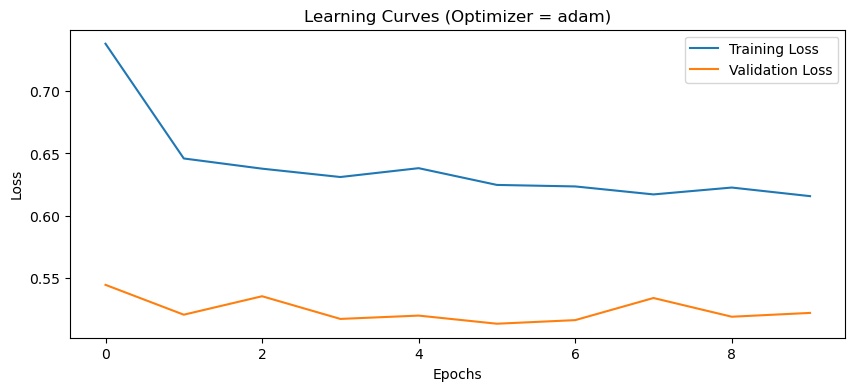

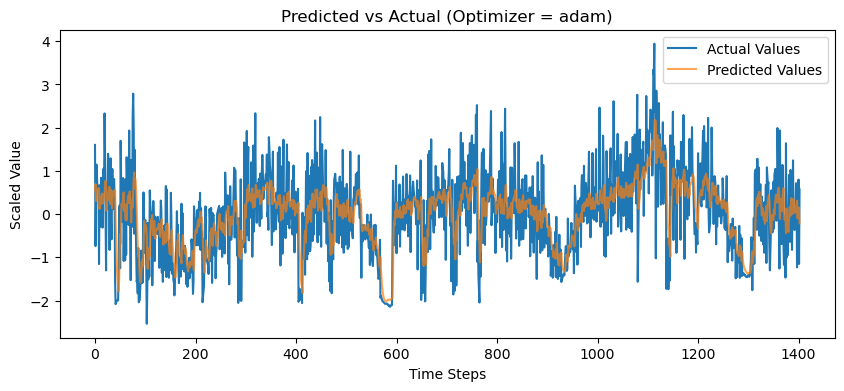

Training with optimizer = sgd
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0145 - val_loss: 0.6820
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7603 - val_loss: 0.5809
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6590 - val_loss: 0.5377
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6083 - val_loss: 0.5283
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6362 - val_loss: 0.5286
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5897 - val_loss: 0.5258
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6306 - val_loss: 0.5231
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6039 - val_loss: 0.5274
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6410 - val_loss: 0.5252
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6447 - val_loss: 0.5251
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train MSE with optimizer = sgd: 0.6166024985665902


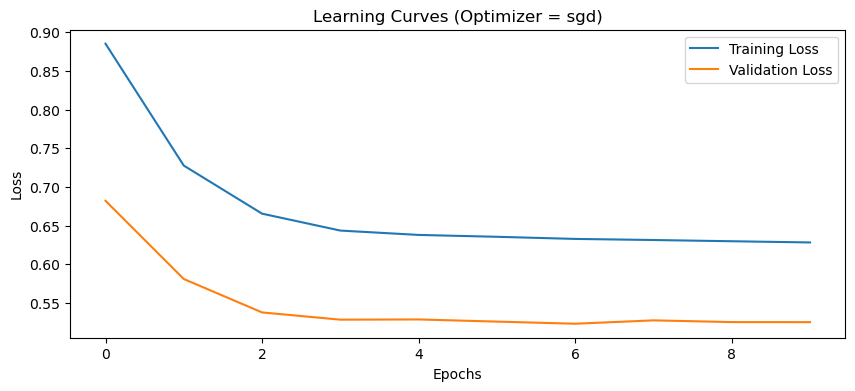

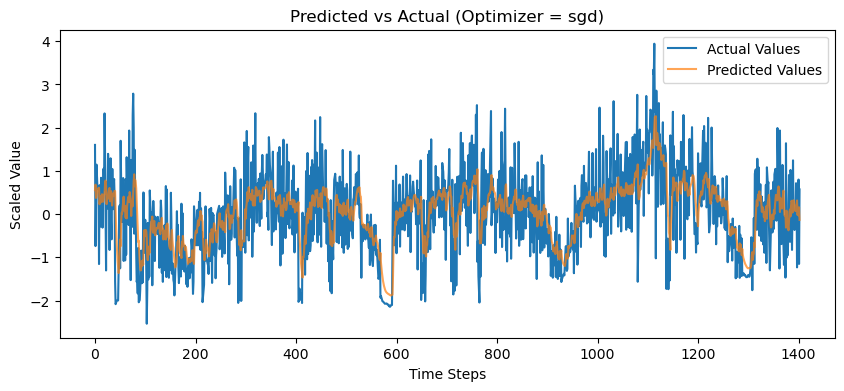

Training with optimizer = rmsprop
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8824 - val_loss: 0.5502
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6455 - val_loss: 0.5421
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6830 - val_loss: 0.5513
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6745 - val_loss: 0.5266
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6056 - val_loss: 0.5213
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ -2s -63604us/step - loss: 0.6139 - val_loss: 0.5165
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6392 - val_loss: 0.5345
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6198 - val_loss: 0.5164
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5926 - val_loss: 0.5213
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6247 - val_loss: 0.5174
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Train MSE with optimizer = rmsprop: 0.6063566437928125


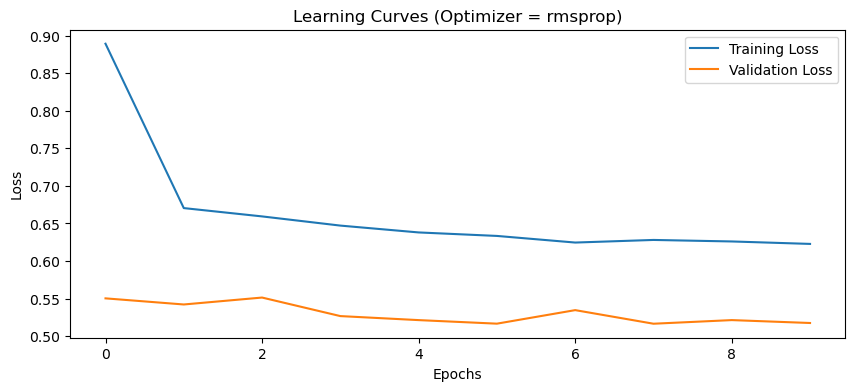

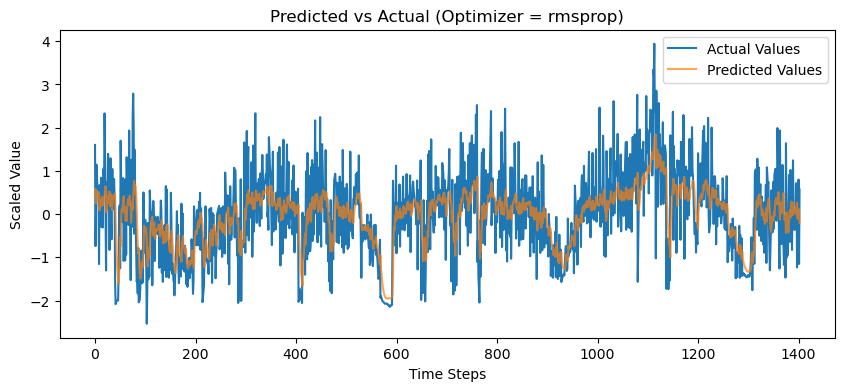

Training with optimizer = adagrad
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9606 - val_loss: 0.7973
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9626 - val_loss: 0.7700
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9204 - val_loss: 0.7472
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8576 - val_loss: 0.7279
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9219 - val_loss: 0.7097
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8476 - val_loss: 0.6928
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8585 - val_loss: 0.6776
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8421 - val_loss: 0.6630
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8076 - val_loss: 0.6491
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8734 - val_loss: 0.6364
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train MSE with optimizer = adagrad: 0.7909780949581281


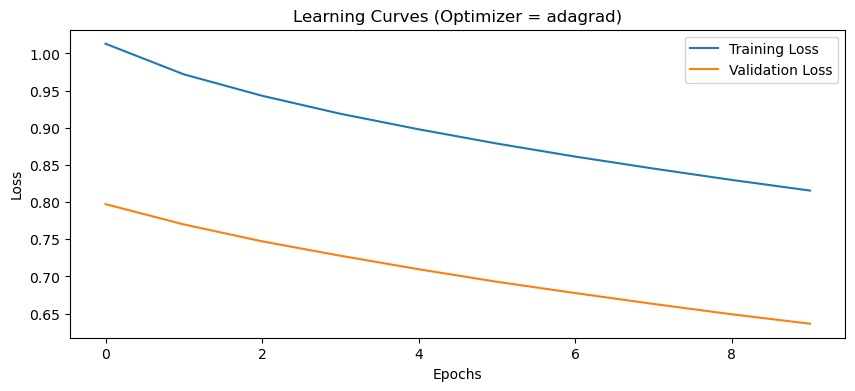

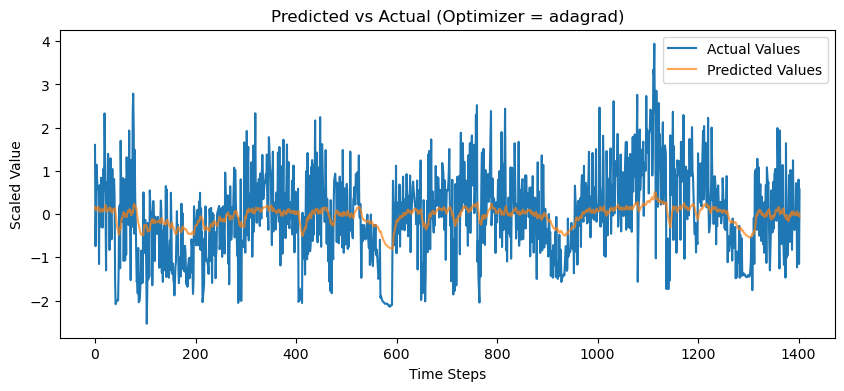

In [79]:
#Iterating 
for optimizer_name, optimizer in optimizers.items():
    #Building the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
    model.add(Dense(1))
    
    #Compiling the model
    model.compile(optimizer=optimizer, loss='mse')
    
    #Training the model and storing
    print(f"Training with optimizer = {optimizer_name}")
    #fit the model
    history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.1, verbose=1)
    
    #Evaluating the model using mean squared error
    y_pred = model.predict(X)
    train_mse = mean_squared_error(y, y_pred)
    print(f"Train MSE with optimizer = {optimizer_name}: {train_mse}")
    
    #Appending the results
    results.append({
        'optimizer': optimizer_name,
        'train_loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'train_mse': train_mse
    })

    #Plotting the learning curves
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Learning Curves (Optimizer = {optimizer_name})")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    #Ploting the predictions x actual values
    plt.figure(figsize=(10, 4))
    plt.plot(y, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values', alpha=0.7)
    plt.title(f"Predicted vs Actual (Optimizer = {optimizer_name})")
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.show()

In [80]:
#transforming the results into a dataframe
results_df = pd.DataFrame(results)

#Identifying the best optmizers
print(results_df[['optimizer', 'train_mse']])

  optimizer  train_mse
0      adam   0.602283
1       sgd   0.616602
2   rmsprop   0.606357
3   adagrad   0.790978


Node Size:
Refers to the number of units or neurons in each layer of the network, affecting the model's learning capacity.

In [81]:
time_steps = 30
X, y = create_sequences(daily_avg_scaled, time_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [82]:
#Node sizes to test
node_sizes = [25, 50, 75, 100]
#empty list to store the results 
results = []

Training with LSTM layer size = 25 nodes
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8810 - val_loss: 0.5903
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6867 - val_loss: 0.5387
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6496 - val_loss: 0.5210
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6507 - val_loss: 0.5235
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6248 - val_loss: 0.5264
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6140 - val_loss: 0.5183
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6679 - val_loss: 0.5161
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5759 - val_loss: 0.5147
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6376 - val_loss: 0.5129
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6080 - val_loss: 0.5172
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train MSE with LSTM layer size = 25 nodes: 0.6013991052007047


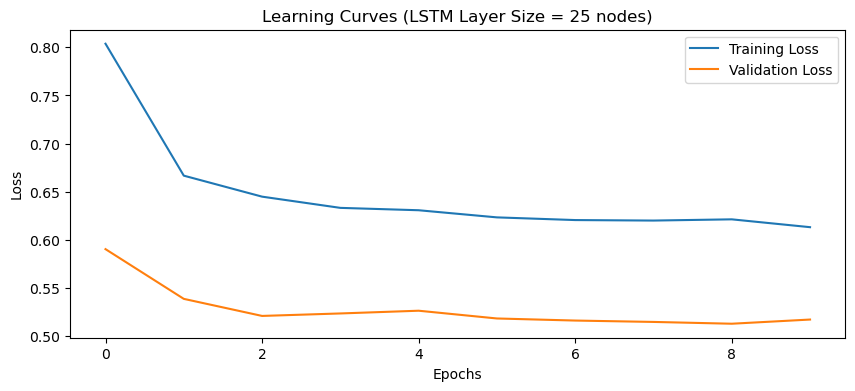

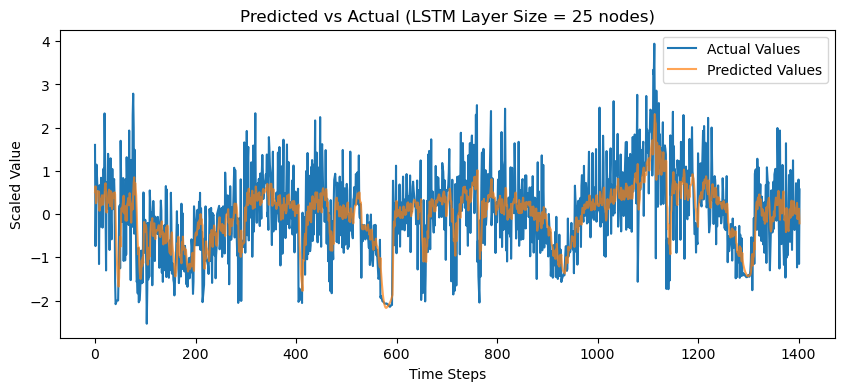

Training with LSTM layer size = 50 nodes
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8586 - val_loss: 0.5660
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6618 - val_loss: 0.5570
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6633 - val_loss: 0.5370
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6432 - val_loss: 0.5537
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6813 - val_loss: 0.5286
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6208 - val_loss: 0.5508
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6007 - val_loss: 0.5281
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6107 - val_loss: 0.5206
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6369 - val_loss: 0.5402
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6228 - val_loss: 0.5164
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train MSE with LSTM layer size = 50 nodes: 0.6093565809048256


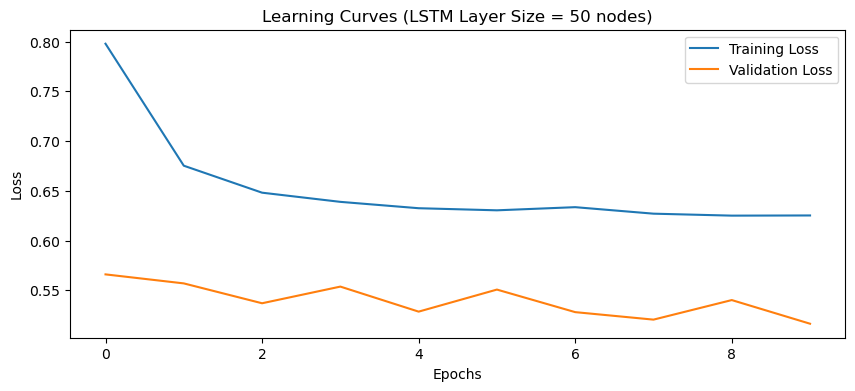

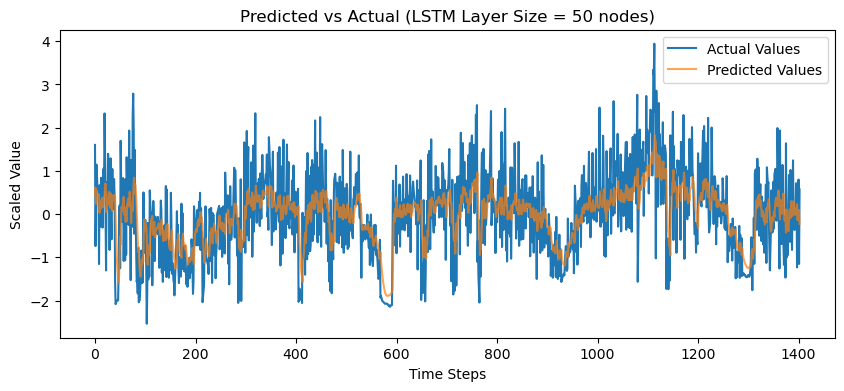

Training with LSTM layer size = 75 nodes
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.7585 - val_loss: 0.5368
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6334 - val_loss: 0.5173
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6002 - val_loss: 0.5192
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6421 - val_loss: 0.5262
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6225 - val_loss: 0.5232
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6141 - val_loss: 0.5423
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6268 - val_loss: 0.5249
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6075 - val_loss: 0.5168
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5999 - val_loss: 0.5218
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6414 - val_loss: 0.5211
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train MSE with LSTM layer size = 75 nodes: 0.6199500955509025


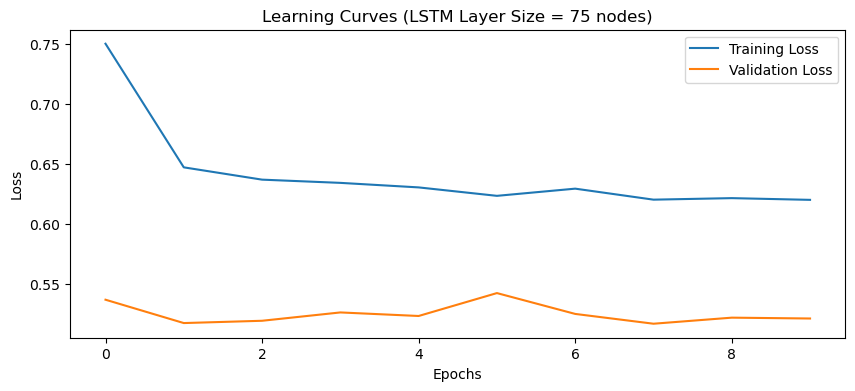

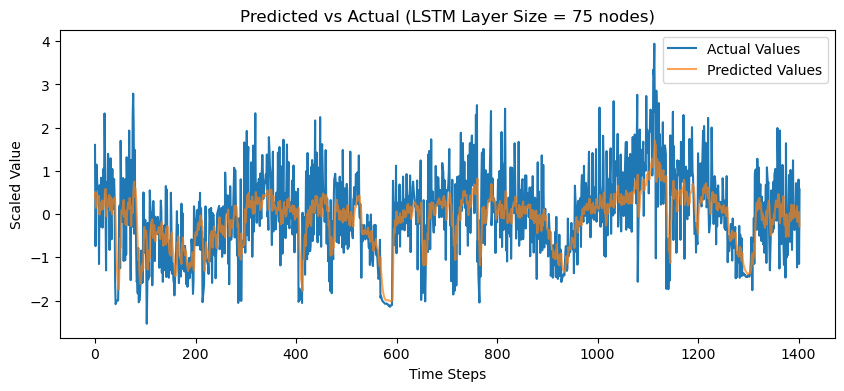

Training with LSTM layer size = 100 nodes
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.9192 - val_loss: 0.5580
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6847 - val_loss: 0.5263
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6653 - val_loss: 0.5310
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6566 - val_loss: 0.5289
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6337 - val_loss: 0.5259
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6231 - val_loss: 0.5265
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6329 - val_loss: 0.5430
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5994 - val_loss: 0.5293
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6183 - val_loss: 0.5261
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6518 - val_loss: 0.5188
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Train MSE with LSTM layer size = 100 nodes: 0.5979820403481537


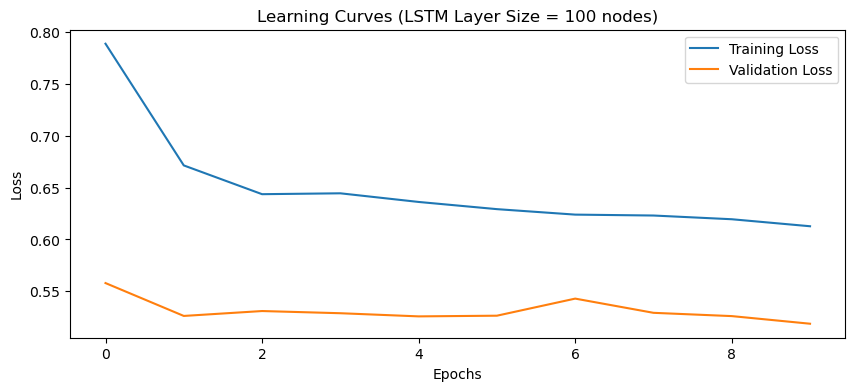

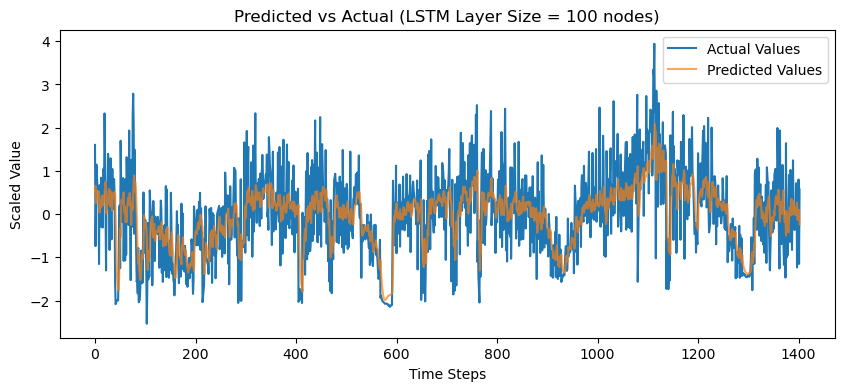

In [83]:
#iterating through node sizes:
for node_size in node_sizes:
    # LSTM model
    model = Sequential()
    model.add(LSTM(node_size, activation='relu', input_shape=(time_steps, 1)))
    model.add(Dense(1))
    
    #Compiling the model
    model.compile(optimizer=Adam(), loss='mse')
    
    #Training the model and storing it
    print(f"Training with LSTM layer size = {node_size} nodes")
    history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.1, verbose=1)
    
    #Evaluating the model using mean squared error
    y_pred = model.predict(X)
    train_mse = mean_squared_error(y, y_pred)
    print(f"Train MSE with LSTM layer size = {node_size} nodes: {train_mse}")
    
    #Appending the results
    results.append({
        'node_size': node_size,
        'train_loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'train_mse': train_mse
    })

    #Plotting the learning curves
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"Learning Curves (LSTM Layer Size = {node_size} nodes)")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    #Plotting the predictions x actual values
    plt.figure(figsize=(10, 4))
    plt.plot(y, label='Actual Values')
    plt.plot(y_pred, label='Predicted Values', alpha=0.7)
    plt.title(f"Predicted vs Actual (LSTM Layer Size = {node_size} nodes)")
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.show()

In [84]:
results_df = pd.DataFrame(results)

#Checking the best node sizes
print(results_df[['node_size', 'train_mse']])

   node_size  train_mse
0         25   0.601399
1         50   0.609357
2         75   0.619950
3        100   0.597982


LSTM with best hyperparameters 
time steps = 30
dropout = 0.4
optmizer = adam
node size = 100

In [127]:
scaler = MinMaxScaler()
daily_avg_scaled = scaler.fit_transform(df_pandas_avg.values.reshape(-1, 1))

In [128]:
#Time Steps
def create_sequences(data, time_steps=30):
    sequences = []
    labels = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
        labels.append(data[i + time_steps])
    return np.array(sequences), np.array(labels)

In [129]:
split = int(0.8 * len(X))  # 80% for training, 20% for testing
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [130]:
#LSTM model
model = Sequential()

#Input layer
model.add(Input(shape=(X.shape[1], X.shape[2])))

#layers
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(units=50))  
model.add(Dropout(0.4))
#Output layer
model.add(Dense(units=1))

#Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Creating an early stopping
early_stopping = EarlyStopping(
   monitor='val_loss',        #Monitor validation loss
   patience=10,               #Number of epochs to wait before stopping
   restore_best_weights=True  #Restore the weights from the epoch with the best validation loss
)

#Train the model on the entire dataset
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.8152 - val_loss: 0.5424
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7192 - val_loss: 0.5243
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6474 - val_loss: 0.5278
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6112 - val_loss: 0.5250
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6265 - val_loss: 0.5334
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6128 - val_loss: 0.5253
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6002 - val_loss: 0.5378
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6814 - val_loss: 0.5294
Epoch 9/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6282 - val_loss: 0.5243
Epoch 10/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6771 - val_loss: 0.5311
Epoch 11/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6171 - val_loss: 0.5434
Epoch 12/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6

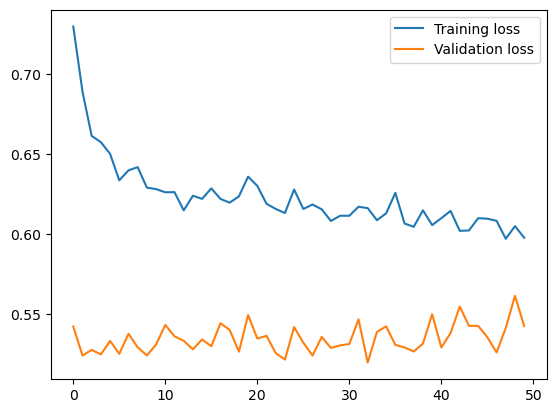

In [131]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [132]:
#Predicting in our entire dataset to check for anomalies 
y_pred_all = model.predict(X)
y_pred_all = y_pred_all.reshape(-1, 1)

#Rescaling the predictions back to the original
y_pred_rescaled_all = scaler.inverse_transform(y_pred_all)
y_rescaled_all = scaler.inverse_transform(y)

#Calculating the absolute error between predictions and true values for the entire dataset
absolute_error = np.abs(y_rescaled_all - y_pred_rescaled_all)

#Define an anomaly threshold 
threshold_all = np.mean(absolute_error) + 3 * np.std(absolute_error) #threshold = 3

print(f"Anomaly Threshold: {threshold_all}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Mean Absolute Error (MAE) for the entire dataset: 9.652292742492794
Anomaly Threshold: 33.190031610820014


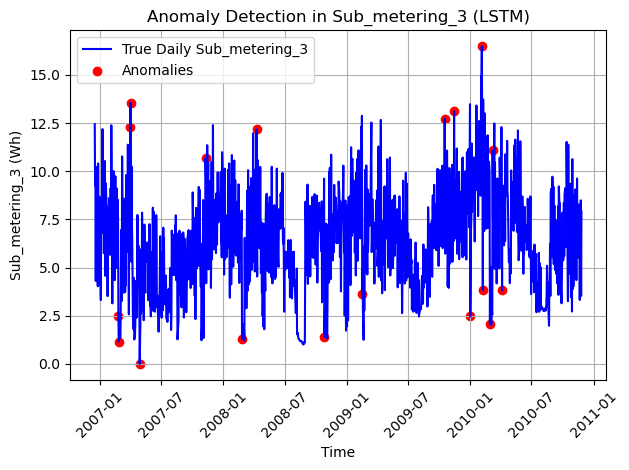

In [144]:
#Plotting the original daily average global active power (Sub_metering_3)
plt.plot(df_pandas_avg.index, df_pandas_avg.values, label='True Daily Sub_metering_3', color='blue')

#Highlighting the anomalies in red using the original values
anomalous_indices_all = df_pandas_avg.index[time_steps:][anomalies_lstm_all.flatten()] #converting multi-dimensional array into a one dim
anomalous_values_all = df_pandas_avg[time_steps:][anomalies_lstm_all.flatten()]

plt.scatter(anomalous_indices_all, anomalous_values_all, color='red', label='Anomalies')

#Plotting
plt.xlabel('Time')
plt.ylabel('Sub_metering_3 (Wh)')
plt.title('Anomaly Detection in Sub_metering_3 (LSTM)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [151]:
print("Anomalies detected by LSTM (Entire Dataset):")
#printing the date and anomaliy value
for date, value in zip(anomalous_indices_all, anomalous_values_all):
    print(f"{date}: {value}")
#checking length
len(anomalous_values_all)

Anomalies detected by LSTM (Entire Dataset):
2007-02-24 00:00:00: 2.473611111111111
2007-02-25 00:00:00: 1.1527777777777777
2007-03-31 00:00:00: 12.279166666666667
2007-04-01 00:00:00: 13.547916666666667
2007-04-28 00:00:00: 0.0
2007-11-09 00:00:00: 10.677083333333334
2008-02-25 00:00:00: 1.288888888888889
2008-04-08 00:00:00: 12.165972222222223
2008-10-26 00:00:00: 1.3979166666666667
2009-02-15 00:00:00: 3.6347222222222224
2009-10-17 00:00:00: 12.72638888888889
2009-11-14 00:00:00: 13.102777777777778
2010-01-01 00:00:00: 2.470833333333333
2010-02-04 00:00:00: 16.488194444444446
2010-02-07 00:00:00: 3.8513888888888888
2010-02-28 00:00:00: 2.05
2010-03-08 00:00:00: 11.090972222222222
2010-04-05 00:00:00: 3.821527777777778


18

References:
https://medium.com/@akashsri306/detecting-anomalies-with-z-scores-a-practical-approach-2f9a0f27458d
https://medium.com/@corymaklin/isolation-forest-799fceacdda4
https://www.geeksforgeeks.org/anomaly-detection-using-isolation-forest/
https://medium.com/wearesinch/simple-anomaly-detection-algorithms-for-streaming-data-machine-learning-92cfaeb6f43b
https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9